# returns

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit
import empyrical

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [3]:
# Disable caching for performance testing
vbt.settings.caching['enabled'] = False
vbt.settings.returns['year_freq'] = '252 days' # same as empyrical

In [4]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
], freq='D')
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, 5], 
    'b': [5, 4, 3, 2, 1],
    'c': [1, 2, 3, 2, 1]
}, index=index).astype(np.float32)

print(ts)

              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0


In [5]:
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [6]:
returns = ts.vbt.pct_change()
print(returns)

big_returns = big_ts.vbt.pct_change()

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000


In [7]:
np.random.seed(42)
benchmark_rets = returns['a'] * np.random.uniform(0.8, 1.2, returns.shape[0])
big_benchmark_rets = big_returns[0] * np.random.uniform(0.8, 1.2, big_returns.shape[0])

In [8]:
# Test year frequency
print(returns.vbt.returns.year_freq)
print(returns['a'].vbt.returns.year_freq)
print(returns.vbt.returns(year_freq='252 days').year_freq)
print(returns['a'].vbt.returns(year_freq='252 days').year_freq)

252 days 00:00:00
252 days 00:00:00
252 days 00:00:00
252 days 00:00:00


In [9]:
print(returns.vbt.returns.ann_factor) # default
print(returns.vbt.returns(year_freq='252 days').ann_factor)

252.0
252.0


In [10]:
print(returns['a'].vbt.returns.daily()) # already daily, do nothing
print(returns.vbt.returns.daily())

%timeit big_returns.vbt.returns.daily()

2018-01-01         NaN
2018-01-02    1.000000
2018-01-03    0.500000
2018-01-04    0.333333
2018-01-05    0.250000
Freq: D, Name: a, dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000
24 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
print(returns['a'].vbt.returns.annual())
print(returns.vbt.returns.annual())

%timeit big_returns.vbt.returns.annual()

2018-01-01    4.0
Freq: 252D, Name: a, dtype: float64
              a    b             c
2018-01-01  4.0 -0.8  2.980232e-08
9.18 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(empyrical.cum_returns(returns['a']))
%timeit empyrical.cum_returns(big_returns[0])

print(returns['a'].vbt.returns.cumulative())
%timeit big_returns[0].vbt.returns.cumulative()

print(returns.vbt.returns.cumulative())
print(returns.vbt.returns.cumulative(start_value=1))
print(returns.vbt.returns.cumulative(start_value=[1, 2, 3])) # also accepts array
%timeit big_returns.vbt.returns.cumulative()

2018-01-01    0.0
2018-01-02    1.0
2018-01-03    2.0
2018-01-04    3.0
2018-01-05    4.0
Freq: D, dtype: float64
2.25 ms ± 67.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-01    0.0
2018-01-02    1.0
2018-01-03    2.0
2018-01-04    3.0
2018-01-05    4.0
Freq: D, Name: a, dtype: float64
212 µs ± 73.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b             c
2018-01-01  0.0  0.0  0.000000e+00
2018-01-02  1.0 -0.2  1.000000e+00
2018-01-03  2.0 -0.4  2.000000e+00
2018-01-04  3.0 -0.6  1.000000e+00
2018-01-05  4.0 -0.8  2.980232e-08
              a    b    c
2018-01-01  1.0  1.0  1.0
2018-01-02  2.0  0.8  2.0
2018-01-03  3.0  0.6  3.0
2018-01-04  4.0  0.4  2.0
2018-01-05  5.0  0.2  1.0
              a    b    c
2018-01-01  1.0  2.0  3.0
2018-01-02  2.0  1.6  6.0
2018-01-03  3.0  1.2  9.0
2018-01-04  4.0  0.8  6.0
2018-01-05  5.0  0.4  3.0
12.4 ms ± 533 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print(empyrical.cum_returns_final(returns['a']))
%timeit empyrical.cum_returns_final(big_returns[0])

print(returns['a'].vbt.returns.total())
%timeit big_returns[0].vbt.returns.total()

print(returns.vbt.returns.total())
%timeit big_returns.vbt.returns.total()

4.000000149011612
220 µs ± 9.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.000000149011612
59.5 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    4.000000e+00
b   -8.000000e-01
c    2.980232e-08
Name: total_return, dtype: float64
4.61 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(empyrical.annual_return(returns['a']))
%timeit empyrical.annual_return(big_returns[0])

print(returns['a'].vbt.returns.annualized())
%timeit big_returns[0].vbt.returns.annualized()

print(returns.vbt.returns.annualized())
%timeit big_returns.vbt.returns.annualized()

1.690786886567203e+35
219 µs ± 3.32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.6907868865671834e+35
111 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    1.690787e+35
b   -1.000000e+00
c    1.502038e-06
Name: annualized_return, dtype: float64
4.6 ms ± 51.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(empyrical.annual_volatility(returns['a'], alpha=3.))
%timeit empyrical.annual_volatility(big_returns[0], alpha=3.)

print(returns['a'].vbt.returns.annualized_volatility(levy_alpha=3.))
%timeit big_returns[0].vbt.returns.annualized_volatility(levy_alpha=3.)

print(returns.vbt.returns.annualized_volatility(levy_alpha=3.))
print(returns.vbt.returns.annualized_volatility(levy_alpha=[1, 2, 3]))
%timeit big_returns.vbt.returns.annualized_volatility(levy_alpha=3.)

2.121838249438074
35.3 µs ± 328 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.121838249438074
396 µs ± 199 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    2.121838
b    0.830587
c    4.466341
Name: annualized_volatility, dtype: float64
a    84.653704
b     2.087463
c     4.466341
Name: annualized_volatility, dtype: float64
6.79 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print(empyrical.calmar_ratio(returns['b']))
%timeit empyrical.calmar_ratio(big_returns[0])

print(returns['b'].vbt.returns.calmar_ratio())
%timeit big_returns[0].vbt.returns.calmar_ratio()

print(returns.vbt.returns.calmar_ratio())
%timeit big_returns.vbt.returns.calmar_ratio()

-1.2500000139698388
346 µs ± 8.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-1.2500000139698388
202 µs ± 70.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a         NaN
b   -1.250000
c    0.000002
Name: calmar_ratio, dtype: float64
14.6 ms ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(empyrical.omega_ratio(returns['c'], risk_free=0.01, required_return=0.1))
%timeit empyrical.omega_ratio(big_returns[0], risk_free=0.01, required_return=0.1)

print(returns['c'].vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1))
%timeit big_returns[0].vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1)

print(returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1))
print(returns.vbt.returns.omega_ratio(risk_free=[0.01, 0.02, 0.03], required_return=0.1))
print(returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=[0.1, 0.2, 0.3]))
%timeit big_returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1)

1.7319528661672228
1.11 ms ± 2.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.7319528661672228
188 µs ± 74.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a         inf
b    0.000000
c    1.731953
Name: omega_ratio, dtype: float64
a        inf
b    0.00000
c    1.60973
Name: omega_ratio, dtype: float64
a         inf
b    0.000000
c    1.727716
Name: omega_ratio, dtype: float64
12.9 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print(empyrical.sharpe_ratio(returns['a'], risk_free=0.01))
%timeit empyrical.sharpe_ratio(big_returns[0], risk_free=0.01)

print(returns['a'].vbt.returns.sharpe_ratio(risk_free=0.01))
%timeit big_returns[0].vbt.returns.sharpe_ratio(risk_free=0.01)

print(returns.vbt.returns.sharpe_ratio(risk_free=0.01))
print(returns.vbt.returns.sharpe_ratio(risk_free=[0.01, 0.02, 0.03]))
%timeit big_returns.vbt.returns.sharpe_ratio(risk_free=0.01)

24.139822936194918
204 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
24.139822936194918
174 µs ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    24.139823
b   -39.938439
c     3.517158
Name: sharpe_ratio, dtype: float64
a    24.139823
b   -41.145646
c     3.068159
Name: sharpe_ratio, dtype: float64
8.44 ms ± 87.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(returns.vbt.returns.deflated_sharpe_ratio(risk_free=0.01))
print(returns.vbt.returns.deflated_sharpe_ratio(risk_free=[0.01, 0.02, 0.03]))
%timeit big_returns.vbt.returns.deflated_sharpe_ratio(risk_free=0.01)

# can specify var_sharpe and nb_trials expclicitly
print(big_returns[0].vbt.returns.deflated_sharpe_ratio(
    risk_free=0.01, 
    var_sharpe=np.var(big_returns.vbt.returns.sharpe_ratio(risk_free=0.01)),
    nb_trials=big_returns.shape[1]
))

a         NaN
b         NaN
c    0.004879
Name: deflated_sharpe_ratio, dtype: float64
a         NaN
b         NaN
c    0.003749
Name: deflated_sharpe_ratio, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/returns/metrics.py:18: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - skew * est_sharpe + ((kurtosis - 1) / 4) * est_sharpe ** 2))


47.6 ms ± 752 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.0


In [20]:
print(empyrical.downside_risk(returns['b'], required_return=0.1))
%timeit empyrical.downside_risk(big_returns[0], required_return=0.1)

print(returns['b'].vbt.returns.downside_risk(required_return=0.1))
%timeit big_returns[0].vbt.returns.downside_risk(required_return=0.1)

print(returns.vbt.returns.downside_risk(required_return=0.1))
print(returns.vbt.returns.downside_risk(required_return=[0.1, 0.2, 0.3]))
%timeit big_returns.vbt.returns.downside_risk(required_return=0.1)

6.920801865722236
79.9 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.920801865722236
183 µs ± 73.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    0.000000
b    6.920802
c    5.874521
Name: downside_risk, dtype: float64
a    0.000000
b    8.463303
c    8.098765
Name: downside_risk, dtype: float64
8.53 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(empyrical.sortino_ratio(returns['b'], required_return=0.1))
%timeit empyrical.sortino_ratio(big_returns[0], required_return=0.1)

print(returns['b'].vbt.returns.sortino_ratio(required_return=0.1))
%timeit big_returns[0].vbt.returns.sortino_ratio(required_return=0.1)

print(returns.vbt.returns.sortino_ratio(required_return=0.1))
print(returns.vbt.returns.sortino_ratio(required_return=[0.1, 0.2, 0.3]))
%timeit big_returns.vbt.returns.sortino_ratio(required_return=0.1)

-15.32336860018125
295 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-15.32336860018125
212 µs ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a          inf
b   -15.323369
c     2.859808
Name: sortino_ratio, dtype: float64
a          inf
b   -15.508129
c    -4.148780
Name: sortino_ratio, dtype: float64
11.3 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print(empyrical.excess_sharpe(returns['a'], benchmark_rets))
%timeit empyrical.excess_sharpe(big_returns[0], benchmark_rets)

print(returns['a'].vbt.returns.information_ratio(benchmark_rets)) # will broadcast
%timeit big_returns[0].vbt.returns.information_ratio(big_benchmark_rets)

print(returns.vbt.returns.information_ratio(benchmark_rets))
%timeit big_returns.vbt.returns.information_ratio(big_benchmark_rets)

-0.5575108270794908
657 µs ± 7.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-0.5575108270794908
The slowest run took 4.20 times longer than the fastest. This could mean that an intermediate result is being cached.
233 µs ± 152 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a   -0.557511
b   -2.718676
c   -1.185416
Name: information_ratio, dtype: float64
10.4 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
print(empyrical.beta(returns['a'], benchmark_rets))
%timeit empyrical.beta(big_returns[0], benchmark_rets)

print(returns['a'].vbt.returns.beta(benchmark_rets))
%timeit big_returns[0].vbt.returns.beta(big_benchmark_rets)

print(returns.vbt.returns.beta(benchmark_rets))
%timeit big_returns.vbt.returns.beta(big_benchmark_rets)

0.7853755820643185
1.74 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.7853755820643185
181 µs ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    0.785376
b    0.252235
c    1.547239
Name: beta, dtype: float64
11.2 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print(empyrical.alpha(returns['a'], benchmark_rets, risk_free=0.01))
%timeit empyrical.alpha(big_returns[0], benchmark_rets, risk_free=0.01)

print(returns['a'].vbt.returns.alpha(benchmark_rets, risk_free=0.01))
%timeit big_returns[0].vbt.returns.alpha(big_benchmark_rets, risk_free=0.01)

print(returns.vbt.returns.alpha(benchmark_rets, risk_free=0.01))
print(returns.vbt.returns.alpha(benchmark_rets, risk_free=[0.01, 0.02, 0.03]))
%timeit big_returns.vbt.returns.alpha(big_benchmark_rets, risk_free=0.01)

21533608.259557564
2.48 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21533608.259557564
272 µs ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    2.153361e+07
b   -1.000000e+00
c   -1.000000e+00
Name: alpha, dtype: float64
a    2.153361e+07
b   -1.000000e+00
c   -1.000000e+00
Name: alpha, dtype: float64
15.3 ms ± 286 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
print(empyrical.tail_ratio(returns['a']))
%timeit empyrical.tail_ratio(big_returns[0])

print(returns['a'].vbt.returns.tail_ratio())
%timeit big_returns[0].vbt.returns.tail_ratio()

print(returns.vbt.returns.tail_ratio())
%timeit big_returns.vbt.returns.tail_ratio()

3.5238094437960337
332 µs ± 46.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.5238094437960337
94.5 µs ± 45.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    3.523809
b    0.436842
c    1.947368
Name: tail_ratio, dtype: float64
31 ms ± 526 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
print(empyrical.value_at_risk(returns.iloc[1:]['a'], cutoff=0.05))
%timeit empyrical.value_at_risk(big_returns[0], cutoff=0.05)

print(returns['a'].vbt.returns.value_at_risk(cutoff=0.05))
%timeit big_returns[0].vbt.returns.value_at_risk(cutoff=0.05)

print(returns.vbt.returns.value_at_risk(cutoff=0.05))
print(returns.vbt.returns.value_at_risk(cutoff=[0.05, 0.06, 0.07]))
%timeit big_returns.vbt.returns.value_at_risk(cutoff=0.05)

0.26250000596046447
162 µs ± 6.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.26250000596046447
108 µs ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    0.2625
b   -0.4750
c   -0.4750
Name: value_at_risk, dtype: float64
a    0.2625
b   -0.4700
c   -0.4650
Name: value_at_risk, dtype: float64
18.4 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
print(empyrical.conditional_value_at_risk(returns.iloc[1:]['a'], cutoff=0.05))
%timeit empyrical.conditional_value_at_risk(big_returns[0], cutoff=0.05)

print(returns['a'].vbt.returns.conditional_value_at_risk(cutoff=0.05))
%timeit big_returns[0].vbt.returns.conditional_value_at_risk(cutoff=0.05)

print(returns.vbt.returns.conditional_value_at_risk(cutoff=0.05))
print(returns.vbt.returns.conditional_value_at_risk(cutoff=[0.05, 0.06, 0.07]))
%timeit big_returns.vbt.returns.conditional_value_at_risk(cutoff=0.05)

0.25
51.6 µs ± 3.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
0.25
115 µs ± 54.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    0.25
b   -0.50
c   -0.50
Name: conditional_value_at_risk, dtype: float64
a    0.25
b   -0.50
c   -0.50
Name: conditional_value_at_risk, dtype: float64
16.9 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print(empyrical.capture(returns['a'], benchmark_rets))
%timeit empyrical.capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.capture(big_benchmark_rets)

print(returns.vbt.returns.capture(benchmark_rets))
%timeit big_returns.vbt.returns.capture(big_benchmark_rets)

0.00691706997447195
421 µs ± 3.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.006917069974471952
328 µs ± 183 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    6.917070e-03
b   -4.091036e-38
c    6.144892e-44
Name: capture, dtype: float64
7.87 ms ± 909 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(empyrical.up_capture(returns['a'], benchmark_rets))
%timeit empyrical.up_capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.up_capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.up_capture(big_benchmark_rets)

print(returns.vbt.returns.up_capture(benchmark_rets))
%timeit big_returns.vbt.returns.up_capture(big_benchmark_rets)

0.0019948153957327634
1.19 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.0019948153957327634
315 µs ± 132 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    1.994815e-03
b   -1.839889e-47
c    3.454480e-53
Name: up_capture, dtype: float64
6.89 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
print(empyrical.down_capture(returns['a'], benchmark_rets))
%timeit empyrical.down_capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.down_capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.down_capture(big_benchmark_rets)

print(returns.vbt.returns.down_capture(benchmark_rets))
%timeit big_returns.vbt.returns.down_capture(big_benchmark_rets)

nan
1.2 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
nan
281 µs ± 115 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a   NaN
b   NaN
c   NaN
Name: down_capture, dtype: float64
6.87 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
print(returns.vbt.returns.drawdown())

%timeit big_returns.vbt.returns.drawdown()

              a    b         c
2018-01-01  0.0  0.0  0.000000
2018-01-02  0.0 -0.2  0.000000
2018-01-03  0.0 -0.4  0.000000
2018-01-04  0.0 -0.6 -0.333333
2018-01-05  0.0 -0.8 -0.666667
16.3 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
print(empyrical.max_drawdown(returns['b']))
%timeit empyrical.max_drawdown(big_returns[0])

print(returns['b'].vbt.returns.max_drawdown())
%timeit big_returns[0].vbt.returns.max_drawdown()

print(returns.vbt.returns.max_drawdown())
%timeit big_returns.vbt.returns.max_drawdown()

-0.7999999910593033
83.4 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-0.7999999910593032
86.3 µs ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    0.000000
b   -0.800000
c   -0.666667
Name: max_drawdown, dtype: float64
11.2 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(returns.vbt.returns.drawdowns)
%timeit big_returns.vbt.returns.drawdowns

print(returns.vbt.returns.drawdowns.max_drawdown())

18.5 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
a    0.000000
b   -0.800000
c   -0.666667
Name: max_drawdown, dtype: float64


In [34]:
print(returns['b'].vbt.returns.stats(benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1))
%timeit big_returns[0].vbt.returns.stats(big_benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1)

print(returns.vbt.returns.stats(benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1))
%timeit big_returns.vbt.returns.stats(big_benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1)

Start                    2018-01-01 00:00:00
End                      2018-01-05 00:00:00
Duration                     5 days 00:00:00
Total Return [%]                         -80
Benchmark Return [%]                  451.86
Annual Return [%]                       -100
Annual Volatility [%]                83.0587
Sharpe Ratio                        -39.9384
Calmar Ratio                           -1.25
Max. Drawdown [%]                        -80
Omega Ratio                                0
Sortino Ratio                       -15.3234
Skew                                -1.06537
Kurtosis                            0.645216
Tail Ratio                          0.436842
Common Sense Ratio                         0
Value at Risk                         -0.475
Alpha                                     -1
Beta                                0.252235
Name: b, dtype: object
5.66 ms ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
       Start        End Duration  Total Return [%]

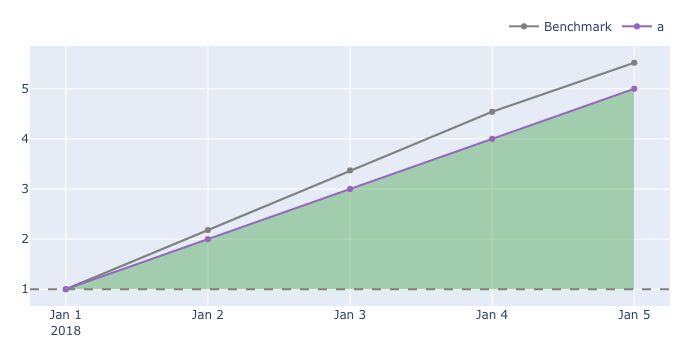

In [35]:
returns['a'].vbt.returns.plot_cum_returns(benchmark_rets).show_png()

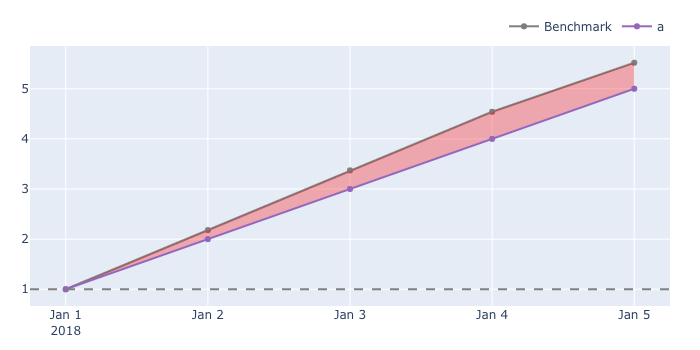

In [36]:
returns['a'].vbt.returns.plot_cum_returns(benchmark_rets, fill_to_benchmark=True).show_png()